****
# Twitter Stock Price Prediction Using Stock Price
***
Welcome to this notebook where we will be exploring the correlation between social media sentiment and stock market movements using statistical machine learning models. In particular, we will be using sentiment analysis and two models, Random Forest and Support Vector Regression, to predict stock market prices based on tweets extracted from Twitter.

To achieve our objective, we have divided the project into the following steps:

- Data Collection & Parsing: We collected stock market data using the yfinance API and fetched tweets using the GetOldTweets API. Preprocessing of the tweets is carried out, which includes removing stop words and hyperlinks.
- Sentiment Analysis: We used VADER to perform sentiment analysis on the tweets. Each tweet is given a sentiment score to determine if it is positive, negative, or neutral.
- Processing: We processed the data, including rows with missing values such as price values. The data, along with the sentiment scores, is then divided into train and test data.
- Applying Regression Models: We used Random Forest and Support Vector Regression models to predict stock market prices. We evaluated and compared the models using RMSE values to determine which model works better for the dataset.

The objective of this notebook is to predict the price of stocks using the data provided and i hope this notebook will provide insights into the correlation between social media sentiment and stock market movements and provide a better understanding of the effectiveness of machine learning models in predicting stock prices. Data would be collected from different source and harnessed to solve the problem. Data Source includes real life streamed tweets
- Some of the data are from kaggle
- real streamed tweets

In [1]:
#Importing the important libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders import OneHotEncoder

***
# Data Collection
***

In [2]:
#reading the data
df = pd.read_pickle("C:/Users/DELL/Downloads/Twitter_Dataset.pkl")
df.head(15)

,close,adj close,articles
2007-01-01,12469.971875,12469.971875,. What Sticks from '06. Somalia Orders Islamis...
2007-01-02,12472.245703,12472.245703,. Heart Health: Vitamin Does Not Prevent Death...
2007-01-03,12474.519531,12474.519531,. Google Answer to Filling Jobs Is an Algorith...
2007-01-04,12480.690430,12480.690430,. Helping Make the Shift From Combat to Commer...
2007-01-05,12398.009766,12398.009766,. Rise in Ethanol Raises Concerns About Corn a...
2007-01-06,12406.503255,12406.503255,. A Status Quo Secretary General. Best Buy and...
2007-01-07,12414.996745,12414.996745,. THE COMMON APPLICATION; Typo.com. Jumbo Bonu...
2007-01-08,12423.490234,12423.490234,. VW Group’s Sales Rose Sharply in 2006. Conso...
2007-01-09,12416.599609,12416.599609,. The Claim: Hot Leftovers Should Cool at Roo...
2007-01-10,12442.160156,12442.160156,. Love Among the Ruins. Dell Says Plant a Tree...


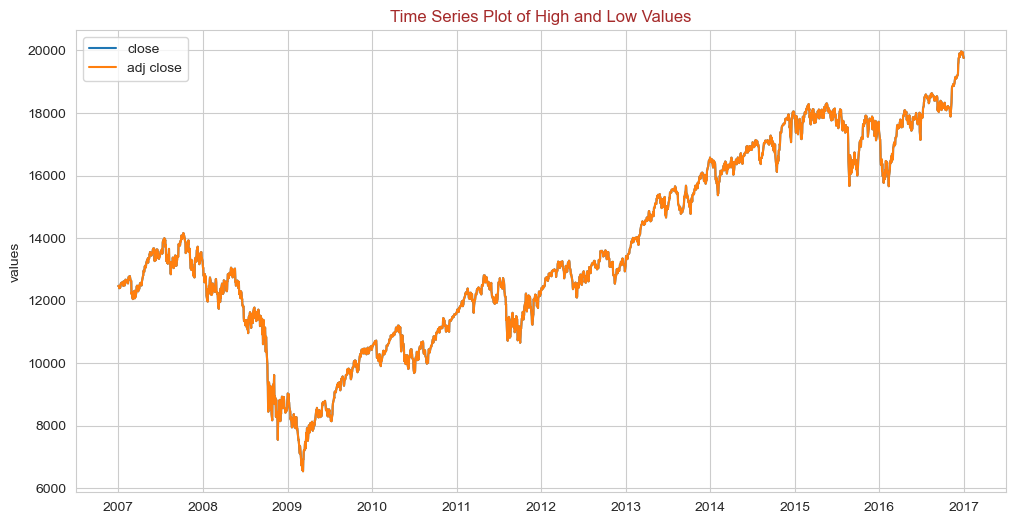

In [3]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12,6)) 
sns.lineplot(x=df.index, y =df["close"], label="close")
sns.lineplot(x=df.index, y =df["adj close"], label="adj close")
plt.ylabel("values")
plt.title("Time Series Plot of High and Low Values", color="brown")
ax.legend()
plt.show()

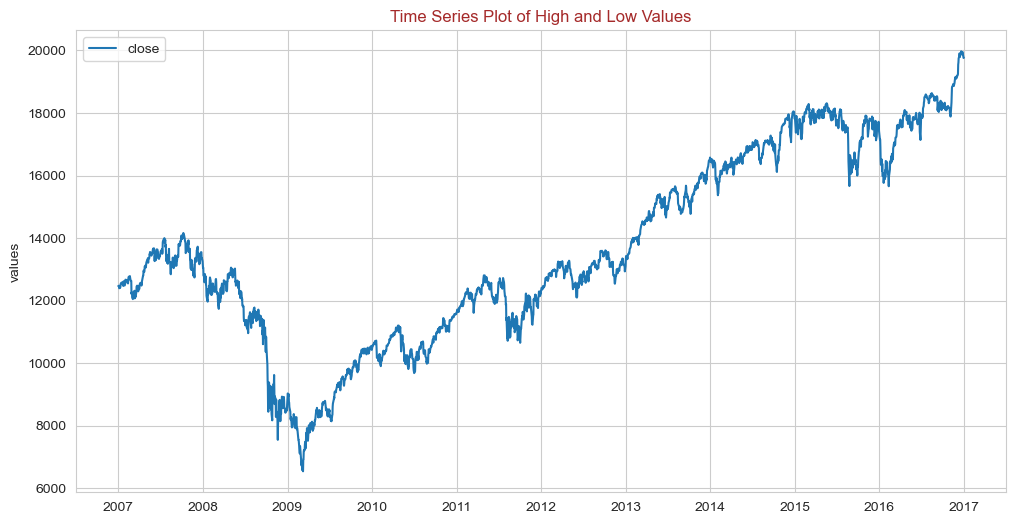

In [4]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12,6)) 
sns.lineplot(x=df.index, y =df["close"], label="close")
plt.ylabel("values")
plt.title("Time Series Plot of High and Low Values", color="brown")
ax.legend()
plt.show()

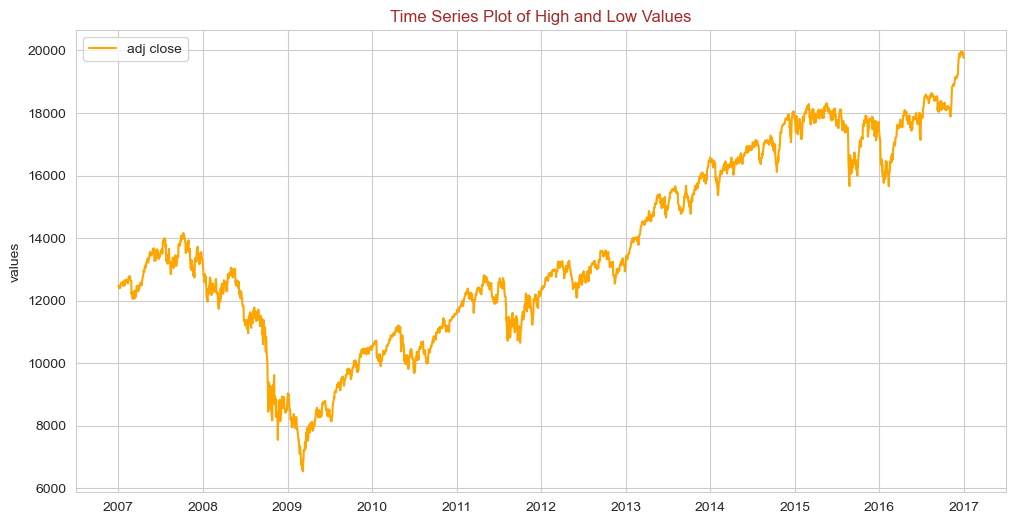

In [5]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12,6)) 
sns.lineplot(x=df.index, y =df["adj close"], label="adj close", color="orange")
plt.ylabel("values")
plt.title("Time Series Plot of High and Low Values", color="brown")
ax.legend()
plt.show()

***This shows that the close and adj close columns are highly correlated. Possibly the same***

In [6]:
df.describe()

,close,adj close
count,3653.000000,3653.000000
mean,13618.122298,13618.122298
std,3044.526618,3044.526618
min,6547.049805,6547.049805
25%,11412.870117,11412.870117
50%,13093.169922,13093.169922
75%,16453.830078,16453.830078
max,19974.619141,19974.619141


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3653 entries, 2007-01-01 to 2016-12-31
Freq: <pandas._libs.properties.CachedProperty object at 0x000002BEC08E1340>
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   close      3653 non-null   float64
 1   adj close  3653 non-null   float64
 2   articles   3653 non-null   object 
dtypes: float64(2), object(1)
memory usage: 114.2+ KB


***
# Functions
The functions used for visualisation, model building and making predictions are defined as follow

In [8]:
def show_distribution(var, name):
    """The functions helps to print out statistical analysis about data and then plots a distribution plot for the data 
    - inputs: It takes in the column to be analysed
    - Returns statistical analyses and visuals for the data"""
    
    sns.set()
    
    #collating the statistical property
    min_val = var.min()
    max_val = var.max()
    mode_val = var.mode()[0]
    median_val = var.median()
    mean_val = var.mean()
    rstd = var.std()
    rvar= np.sqrt(rstd)
    
    print("The statistical values are as follows:\n Minimum value:{:.2f}\n Maximum value: {:.2f}\n Mode: {:.2f} \n Mean: {:.2f} \n Standard Deviation: {:.2f} \n Variance: {:.2f} \n Median: {:.2f}"\
          .format(min_val, max_val, mode_val, mean_val, rstd, rvar, median_val))
    
    #creating a figure with 2 rows and 1 columns where the upperpart is dominated by the histplot and the
    #bottom by the 
    fig, ax = plt.subplots(2,1, figsize=(12,6))
    
    #Creating the histogram
    sns.histplot(var, ax=ax[0])
    ax[0].set_ylabel("Frequency")
    
    #fitting the statiscal lines
    ax[0].axvline(x=min_val, color='gray', linestyle='dashed', linewidth=2)
    ax[0].axvline(x=median_val, color='cyan', linestyle='dashed', linewidth=2)
    ax[0].axvline(x=mode_val, color='red', linestyle='dashed', linewidth=2)
    ax[0].axvline(x=mean_val, color='orange', linestyle='dashed', linewidth=2)
    ax[0].axvline(x=rvar, color='white', linestyle='dashed', linewidth=2)
    ax[0].axvline(x=max_val, color='gray', linestyle='dashed', linewidth=2)
    
    #creating the boxplot
    sns.boxplot(x=var, ax=ax[1])
    ax[1].axvline(x=min_val, color='gray', linestyle='dashed', linewidth=2, label="Minimum Value")
    ax[1].axvline(x=median_val, color='cyan', linestyle='dashed', linewidth=2, label="Median")
    ax[1].axvline(x=mode_val, color='red', linestyle='dashed', linewidth=2, label="Mode")
    ax[1].axvline(x=mean_val, color='orange', linestyle='dashed', linewidth=2, label="Mean")
    ax[1].axvline(x=rvar, color='white', linestyle='dashed', linewidth=2, label="Variance")
    ax[1].axvline(x=max_val, color='gray', linestyle='dashed', linewidth=2, label="Standard Deviation")
    
    fig.suptitle(f"Data Distribution for {name}", color="brown")
    plt.legend()
    
    plt.show()

In [9]:
# Create a new column for sentiment analysis
def analyser(dt):
    """function creates a new column in the dataframe and helps to calculate polarity
    Input - Takes in the raw data
    Output - takes the output data
    """
    df = dt.copy()
    analyzer = SentimentIntensityAnalyzer()
    df['sentiment'] = df['articles'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
    return df

In [10]:
def build_model(dt, model):
    "build the model"
    df = dt.copy()
    
    #splitting the dataset
    X = df[["sentiment"]]
    y = df["mean"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
    
    if model == "rg":
        #building the model
        model = make_pipeline(
            SimpleImputer(),
            Ridge()
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse= np.sqrt(mse)
        intercept = model.named_steps["ridge"].intercept_
        coef = model.named_steps["ridge"].coef_
        return model, rmse, intercept, coef
    
    elif model == "lr":
       #building the model
        model = make_pipeline(
            SimpleImputer(),
            LinearRegression(fit_intercept=True)
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse= np.sqrt(mse)
        intercept = model.named_steps["linearregression"].intercept_
        coef = model.named_steps["linearregression"].coef_
        return model, rmse, intercept, coef
    
    elif model == 'svm':
        #building the model
        model = make_pipeline(
            SimpleImputer(),
            SVR()
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse= np.sqrt(mse)
        intercept = model.named_steps["svr"].intercept_
        coef = model.named_steps["svr"].coef_
        return model, rmse
    
    else :
        #building the model
        model = make_pipeline(
            SimpleImputer(),
            RandomForestRegressor()
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse= np.sqrt(mse)
        intercept = model.named_steps["randomforestregressor"].intercept_
        coef = model.named_steps["randomforestregressor"].coef_
        return model, rmse
    

In [63]:
def build_model2(dt, model):
    "build the model for TESLA stock Price Prediction"
    df = dt.copy()
    #splitting the dataset
    X = df[["sentiment"]]
    y = df["mean"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
    
    if model == "rg":
        #building the model
        model = Ridge()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse= np.sqrt(mse)
        intercept = model.intercept_
        coef = model.coef_
        return model, rmse, intercept, coef
    
    elif model == "lr":
       #building the model
        model = LinearRegression(fit_intercept=True)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse= np.sqrt(mse)
        intercept = model.intercept_
        coef = model.coef_
        return model, rmse, intercept, coef

In [24]:
def make_prediction(article, model):
    # Create a new column for sentiment analysis
    df = pd.DataFrame({"article": article}, index=[0])
    analyzer = SentimentIntensityAnalyzer()
    df["sentiment"] = df["article"].apply(lambda x: analyzer.polarity_scores(x)['compound'])
    data = df["sentiment"]
    data = pd.DataFrame(data, index=[0])
    prediction = model.predict(data)[0].round(2)
    return f"Predicted Stock price: ${prediction}"

In [55]:
def make_prediction2(data, model):
    # Create a new column for sentiment analysis
    df = pd.DataFrame({"article":data}, index=[0])
    analyzer = SentimentIntensityAnalyzer()
    df["score"] = df["article"].apply(lambda x: analyzer.polarity_scores(x)['compound'])
    data = df['score']
    data = pd.DataFrame(data, index=[0])
    prediction = model.predict(data)[0].round(2)
    return f"Predicted Stock price: ${prediction}"

In [14]:
def build_model3(dt):
    "build the model"
    df = dt.copy()
    
    #splitting the dataset
    X = df[["sentiment"]]
    y = df["mean"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
    
    #building the model
    model = make_pipeline(
        SimpleImputer(),
        Ridge()
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse= np.sqrt(mse)
    
    intercept = model.named_steps["ridge"].intercept_
    coef = model.named_steps["ridge"].coef_
    
    return model, rmse, intercept, coef

***
# Building Process
***

In [15]:
#uncomment if not yet installed in your venv
#!pip install vaderSentiment


***Creating a mean column to approximate the prices for opening and closing***

In [16]:
#Creating new dataframe since it looks like the adj close and close columns are similar
df["mean"] = (df["close"] + df["adj close"])/2

The statistical values are as follows:
 Minimum value:6547.05
 Maximum value: 19974.62
 Mode: 17813.39 
 Mean: 13618.12 
 Standard Deviation: 3044.53 
 Variance: 55.18 
 Median: 13093.17


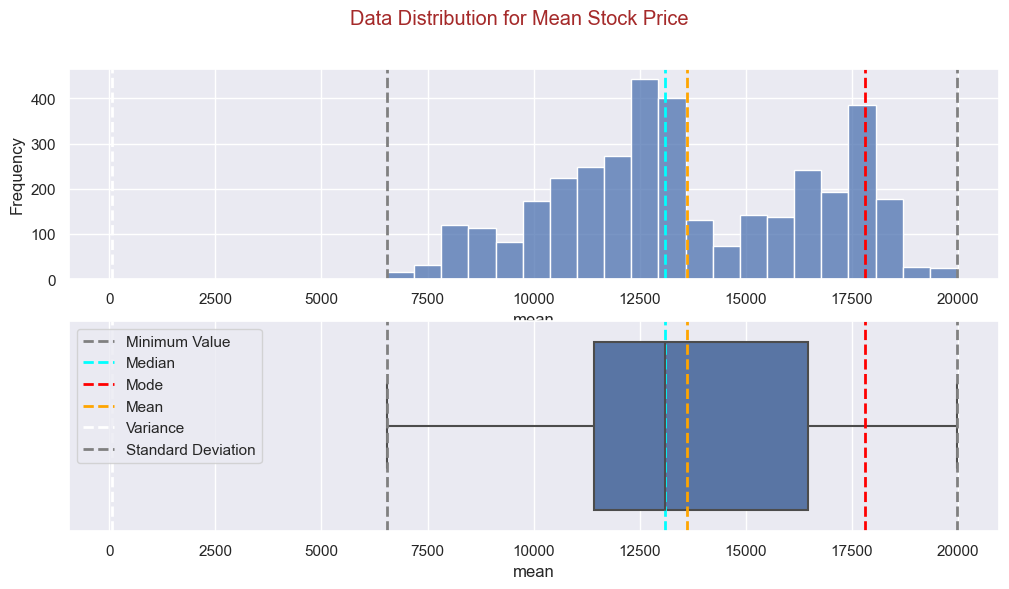

In [17]:
show_distribution(df["mean"], "Mean Stock Price")

In [18]:
df1 = analyser(df)
df1.head(10)

,close,adj close,articles,mean,sentiment
2007-01-01,12469.971875,12469.971875,. What Sticks from '06. Somalia Orders Islamis...,12469.971875,-0.9814
2007-01-02,12472.245703,12472.245703,. Heart Health: Vitamin Does Not Prevent Death...,12472.245703,-0.9576
2007-01-03,12474.519531,12474.519531,. Google Answer to Filling Jobs Is an Algorith...,12474.519531,-0.9990
2007-01-04,12480.690430,12480.690430,. Helping Make the Shift From Combat to Commer...,12480.690430,-0.9982
2007-01-05,12398.009766,12398.009766,. Rise in Ethanol Raises Concerns About Corn a...,12398.009766,-0.9885
2007-01-06,12406.503255,12406.503255,. A Status Quo Secretary General. Best Buy and...,12406.503255,-0.9650
2007-01-07,12414.996745,12414.996745,. THE COMMON APPLICATION; Typo.com. Jumbo Bonu...,12414.996745,-0.9972
2007-01-08,12423.490234,12423.490234,. VW Group’s Sales Rose Sharply in 2006. Conso...,12423.490234,-0.9601
2007-01-09,12416.599609,12416.599609,. The Claim: Hot Leftovers Should Cool at Roo...,12416.599609,-0.9846
2007-01-10,12442.160156,12442.160156,. Love Among the Ruins. Dell Says Plant a Tree...,12442.160156,-0.9772


The statistical values are as follows:
 Minimum value:-1.00
 Maximum value: 1.00
 Mode: -1.00 
 Mean: -0.76 
 Standard Deviation: 0.58 
 Variance: 0.76 
 Median: -0.99


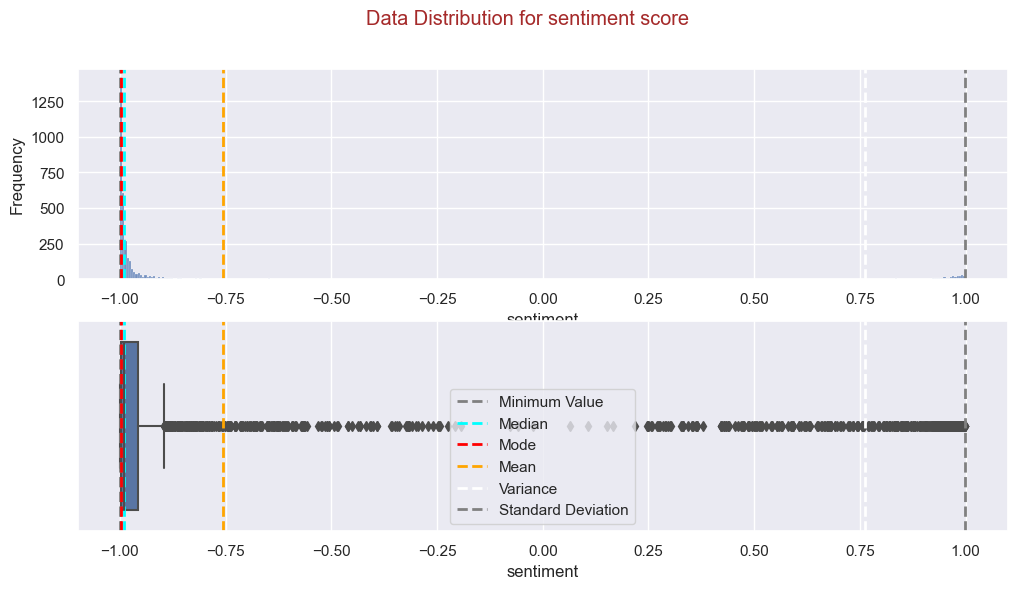

In [19]:
show_distribution(df1["sentiment"], "sentiment score")

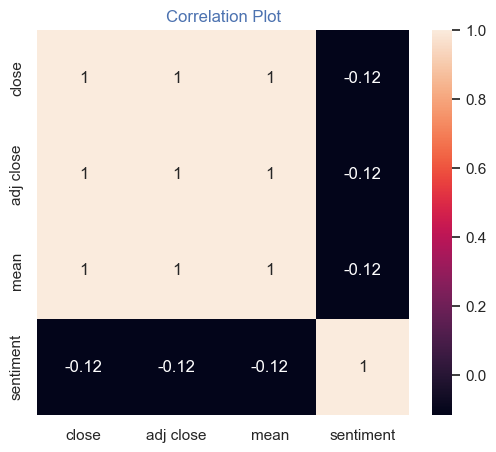

In [20]:
#correlation plot of features
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(df1.corr(), annot=True)
plt.title("Correlation Plot", color="b")
plt.show()

In [21]:
#building the model with already defined functions
model1, rmse1, intercept1, coef1 = build_model(df1,"lr")
print(f"The equation can be expressed as: Price = {intercept1} * sentiment + {coef1}")
print(f"The root mean square error is {rmse1}")

The equation can be expressed as: Price = 13121.877957529943 * sentiment + [-652.0920394]
The root mean square error is 3014.4607549930374


In [25]:
#making prediction on a sample string
make_prediction(". A Status Quo Secretary General. Best Buy and Circuit City Report Brisk Sales for December. China Currency Near Parity With Hong Kong’s Dollar. Ex-Merrill Lynch Analyst Sentenced for Insider Trading. Companies Pay Dearly for Tech Trade Show. France: Inmate Suspected of Cannibalism. Mr. Ford Gets the Last Laugh. San Franciscans Hurl Their Rage at Parking Patrol. Abroad at Home. Monkey on a Tiger. Who Is Best at R&D?. Tanzanian Woman Is Chosen for U.N.’s 2nd Highest Post. Leaked Notes on &#8217;08 Show Giuliani Without the Spin. Images of Hanging Make Hussein a Martyr to Many. Just Days Into the Year, Killings Toll Hits 8 in New Orleans. Regulators Issue Rules on High-Risk Dealings. Iraqi Premier Announces Militia Crackdown. Chirac Says Time Proves France Was Right to Resist War. Verizon to Announce Plan for TV Shows on Cellphones. Goal Is to Look Good, Writer of Democratic Memoir Admits. Schwarzenegger Opens in a Sequel. San Francisco to Go Wireless. Tijuana Police Suspend Patrols After Soldiers Seize Their Guns. Safe as Milk?. Editor’s E-Mail May Be Used in Suit Against The Times. A Renegade’s Tale of His Scorn for Japan’s ‘Club of Old Men’. China Moves to Tighten the Money Supply. Google Makes Another Investment in the Internet in China. Colorado, Still Recovering From 2 Storms, Is Hit With a 3rd. How I Spent My Summer Vacation: Now a Major Motionless Book. Surge in Jobs Sends Markets Lower. Katrina Victims Find a Solution: Modular House. A Meeting With Gerald Ford. Job Growth Is Strong, Surprising Economists. Encouraging More Reality in Economics. U.N. Expels 6 in Sex Case. Germany: Sentence Trial for 9/11 Friend. Britain: New Restaurant on Radiation Trail. Iran Should Give Sanctions &#8216;Serious Response,&#8217; China Says. The Senate’s Task on Warming. Ryan Clark Crocker, a Diplomat Used to Danger. Search Continues for Survivors of Indonesian Ferry Accident. The Vanishing Man of the Forest. At Armenian Churches, a Distinct Observance Today. Making No Small Plans. American Diplomat to Visit Strife-Torn Somali Capital. Zalmay Khalilzad, on to a New Trouble Spot. Ties to Communist Secret Police Snare Polish Bishop. Copyrights and Congress. Monument to the Planet Suffers a Hard Fall to Earth. Health Guidelines Suggested for Models. France: Paris Driver Opens Fire; No Injuries. Colombia: 6-Year Hostage Flees Rebels. Sri Lanka: Bomb Attack on Bus Kills 5. China Media Battle Hints at Shift on Intellectual Property. Highly Paid Chief Is Paid $210 Million to Go Away. The Land of Rising Conservation. Viacom Selects President for MTV International Unit. Bush Facing Deep Divide Over More Troops for Iraq. At Home Depot, the New Chief Needs to Sell an Old Story to Wall Street. Germany: What’s in It for Gelnhausen?. A Future With the Wind. A New Commander, in Step With the White House on Iraq. Tipping Over a Defense of Enron. Appeals Court Reverses Convictions of 2 Westar Energy Executives. Day After Killings, a Hamas Leader Calls for a Truce. Dow&#8217;s Dogs Still Having Their Day. U.S. and Japan Issue Warnings to North Korea on Nuclear Test. Britain: Cartoons Protester Convicted. Chile: California Sailor Rescued. Canada: Liberal Lawmaker Defects. Battlegrounds: An Op-Ed Series. Sunday's Breakfast Menu: Jan. 7. Who Will Bring the Internet to Your TV?. Fun Facts. Tesla Chargers. The Macworld-C.E.S. Conflict. In da Car at Dakar", model1)

'Predicted Stock price: $13751.15'

***

# Predicting Stock Price for Tesla
***

In [26]:
#importing the file
from zipfile import ZipFile
import pandas as pd

filepath = "C:/Users/DELL/OneDrive/Documents/Data/stock_tweets.csv[1].zip"

with ZipFile(filepath, "r") as zippy:
    zippy.extractall("C:/Users/DELL/OneDrive/Documents/Data")

df2 = pd.read_csv("C:/Users/DELL/OneDrive/Documents/Data/stock_tweets.csv")
df2.head()

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [27]:
df2 = df2[df2["Stock Name"] == "TSLA"]

In [28]:
df2.head(30)

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."
5,2022-09-29 22:25:53+00:00,@RealDanODowd @Tesla This is you https://t.co/...,TSLA,"Tesla, Inc."
6,2022-09-29 22:24:22+00:00,For years @WholeMarsBlog viciously silenced @T...,TSLA,"Tesla, Inc."
7,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,TSLA,"Tesla, Inc."
8,2022-09-29 22:23:28+00:00,50 likes for some $SPY $TSLA charts to study!\...,TSLA,"Tesla, Inc."
9,2022-09-29 22:15:01+00:00,@MrJames__321 @KellyRoofing @TeslaSolar @elonm...,TSLA,"Tesla, Inc."


In [29]:
df2['Date'] = pd.to_datetime(df2['Date'])

In [30]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37422 entries, 0 to 37421
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   Date          37422 non-null  datetime64[ns, UTC]
 1   Tweet         37422 non-null  object             
 2   Stock Name    37422 non-null  object             
 3   Company Name  37422 non-null  object             
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 1.4+ MB


In [31]:
# Convert the date column to datetime format
df2['Date'] = pd.to_datetime(df2['Date'])

# Group the data by day and concatenate the tweets in a row separated by commas
grouped_data = df2.groupby(pd.Grouper(key='Date', freq='D'))["Tweet"].apply(lambda x: ', '.join(x)).reset_index()

In [32]:
grouped_data["Tweet"][3]

'If you really want to be successful in life, forget about the girls and focus on one woman, she will help you achieve anything. \n\n$TSLA #Tesla, It’s as simple as this for Monday. \n\nWe either 1/ fuck up the $TSLAQ shorts and straight moon or 2/ we buy the fucking dip and see gains in the long run. \n\nLong term investors win either way. \n\nLFG!🔥\n\n$TSLA #Tesla https://t.co/7oo6qkOxxU, Tesla is only a 10x away from ~10M annual deliveries.\n\n$TSLA @elonmusk, I’m still so pumped!\n\nIs there any other company on earth that makes its investors so happy?\n\n$TSLA, $TSLA EPS is ~$4 now!\n\nTrailing 12-month P/E is now &lt; ~200!\n\nSomething\'s gotta give ..., Wonderful results in the middle of unprecedented supply chain challenge! Congratulations, @elonmusk @Tesla team. https://t.co/jDdDeLp5Uo, The off-the-charts $TSLA growth story continues: \n🔌🔋⚡️🚗 https://t.co/To6bFJ49Vv, Tesla "Full Self Driving" beta videos seem to have dropped to zero. I wonder why?\n\n$TSLA $TSLAQ @TaylorOgan 

***The tweets above shows that each tweets categorised daily based on the prescribed search contains 100+ tweets.***

In [33]:
grouped_data

,Date,Tweet
0,2021-09-30 00:00:00+00:00,"In other words, AMD has been giving Tesla pref..."
1,2021-10-01 00:00:00+00:00,Pelosi still scrambling to find enough votes t...
2,2021-10-02 00:00:00+00:00,When the fuzz has a car that can keep up with ...
3,2021-10-03 00:00:00+00:00,"If you really want to be successful in life, f..."
4,2021-10-04 00:00:00+00:00,STOCKS I AM WATCHING THIS WEEK \n\n$CEI \n$AMC...
...,...,...
360,2022-09-25 00:00:00+00:00,"When I drive on FSD Beta, I know Tesla full se..."
361,2022-09-26 00:00:00+00:00,$TSLA - Above 273 - Trade Idea 💡 - Sept 30 280...
362,2022-09-27 00:00:00+00:00,4 years ago today I picked up my dream car. I ...
363,2022-09-28 00:00:00+00:00,⚡️Watchlist for 9/27/22⚡️\n\n✅ $SPY \n📈C &gt; ...


***
# Collecting the stock Price data using yahoo API for Tesla
***

In [34]:
import yfinance as yf

# Set the date range for which to retrieve stock price data
start_date = '2021-09-30'
end_date = '2022-09-29'

# Get the Tesla stock data for the specified date range
tsla = yf.download('TSLA', start=start_date, end=end_date)

# Print the head of the DataFrame to verify it was loaded correctly
print(tsla.head())


[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   

              Volume  
Date                  
2021-09-30  53868000  
2021-10-01  51094200  
2021-10-04  91449900  
2021-10-05  55297800  
2021-10-06  43898400  


In [35]:
tsla.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2021-09-30 to 2022-09-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       251 non-null    float64
 1   High       251 non-null    float64
 2   Low        251 non-null    float64
 3   Close      251 non-null    float64
 4   Adj Close  251 non-null    float64
 5   Volume     251 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.7 KB


In [36]:
grouped_data["Date"] = pd.to_datetime(grouped_data["Date"]).dt.strftime('%Y-%m-%d')
grouped_data["Date"] = pd.to_datetime(grouped_data['Date'])

In [37]:
grouped_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    365 non-null    datetime64[ns]
 1   Tweet   365 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 5.8+ KB


In [38]:
dfx = pd.merge(grouped_data, tsla, on="Date")

In [39]:
dfx

,Date,Tweet,Open,High,Low,Close,Adj Close,Volume
0,2021-09-30,"In other words, AMD has been giving Tesla pref...",260.333344,263.043335,258.333344,258.493347,258.493347,53868000
1,2021-10-01,Pelosi still scrambling to find enough votes t...,259.466675,260.260010,254.529999,258.406677,258.406677,51094200
2,2021-10-04,STOCKS I AM WATCHING THIS WEEK \n\n$CEI \n$AMC...,265.500000,268.989990,258.706665,260.510010,260.510010,91449900
3,2021-10-05,Most Mentioned Tickers on WSB (via Swaggy Stoc...,261.600006,265.769989,258.066681,260.196655,260.196655,55297800
4,2021-10-06,If you invested $1K into these #assets at the ...,258.733337,262.220001,257.739990,260.916656,260.916656,43898400
...,...,...,...,...,...,...,...,...
246,2022-09-22,@Teslaconomics Hold tight $TSLA investors. Our...,299.859985,301.290009,285.820007,288.589996,288.589996,70545400
247,2022-09-23,3. Scanning for Option Trades\n\nPICK 3-5 Stoc...,283.089996,284.500000,272.820007,275.329987,275.329987,63748400
248,2022-09-26,$TSLA - Above 273 - Trade Idea 💡 - Sept 30 280...,271.829987,284.089996,270.309998,276.010010,276.010010,58076900
249,2022-09-27,4 years ago today I picked up my dream car. I ...,283.839996,288.670013,277.510010,282.940002,282.940002,61925200


In [40]:
# Create a new column for sentiment analysis for TESLA stocks
def analyser2(dt):
    """function creates a new column in the dataframe and helps to calculate polarity
    Input - Takes in the raw data
    Output - takes the output data
    """
    df = dt.copy()
    analyzer = SentimentIntensityAnalyzer()
    df['sentiment'] = df['Tweet'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
    return df

dfx = analyser2(dfx)

In [41]:
#dfx.set_index("Date", inplace=True)
dfx

,Date,Tweet,Open,High,Low,Close,Adj Close,Volume,sentiment
0,2021-09-30,"In other words, AMD has been giving Tesla pref...",260.333344,263.043335,258.333344,258.493347,258.493347,53868000,0.9998
1,2021-10-01,Pelosi still scrambling to find enough votes t...,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,0.9998
2,2021-10-04,STOCKS I AM WATCHING THIS WEEK \n\n$CEI \n$AMC...,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,0.9993
3,2021-10-05,Most Mentioned Tickers on WSB (via Swaggy Stoc...,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,0.9992
4,2021-10-06,If you invested $1K into these #assets at the ...,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,0.9998
...,...,...,...,...,...,...,...,...,...
246,2022-09-22,@Teslaconomics Hold tight $TSLA investors. Our...,299.859985,301.290009,285.820007,288.589996,288.589996,70545400,0.9972
247,2022-09-23,3. Scanning for Option Trades\n\nPICK 3-5 Stoc...,283.089996,284.500000,272.820007,275.329987,275.329987,63748400,0.9994
248,2022-09-26,$TSLA - Above 273 - Trade Idea 💡 - Sept 30 280...,271.829987,284.089996,270.309998,276.010010,276.010010,58076900,0.9991
249,2022-09-27,4 years ago today I picked up my dream car. I ...,283.839996,288.670013,277.510010,282.940002,282.940002,61925200,0.9994


The statistical values are as follows:
 Minimum value:-1.00
 Maximum value: 1.00
 Mode: 1.00 
 Mean: 0.99 
 Standard Deviation: 0.13 
 Variance: 0.36 
 Median: 1.00


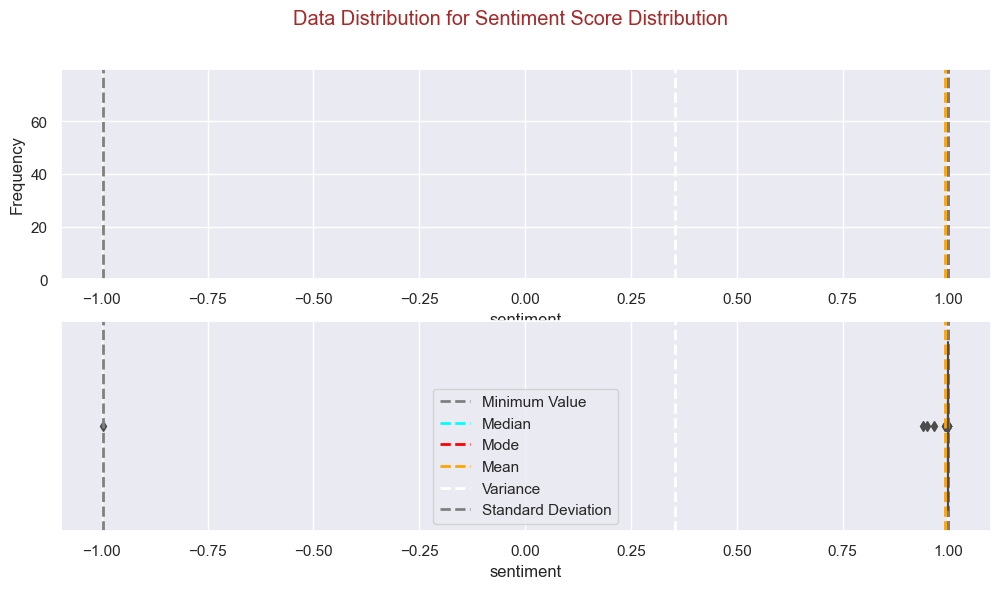

In [42]:
show_distribution(dfx["sentiment"], "Sentiment Score Distribution")

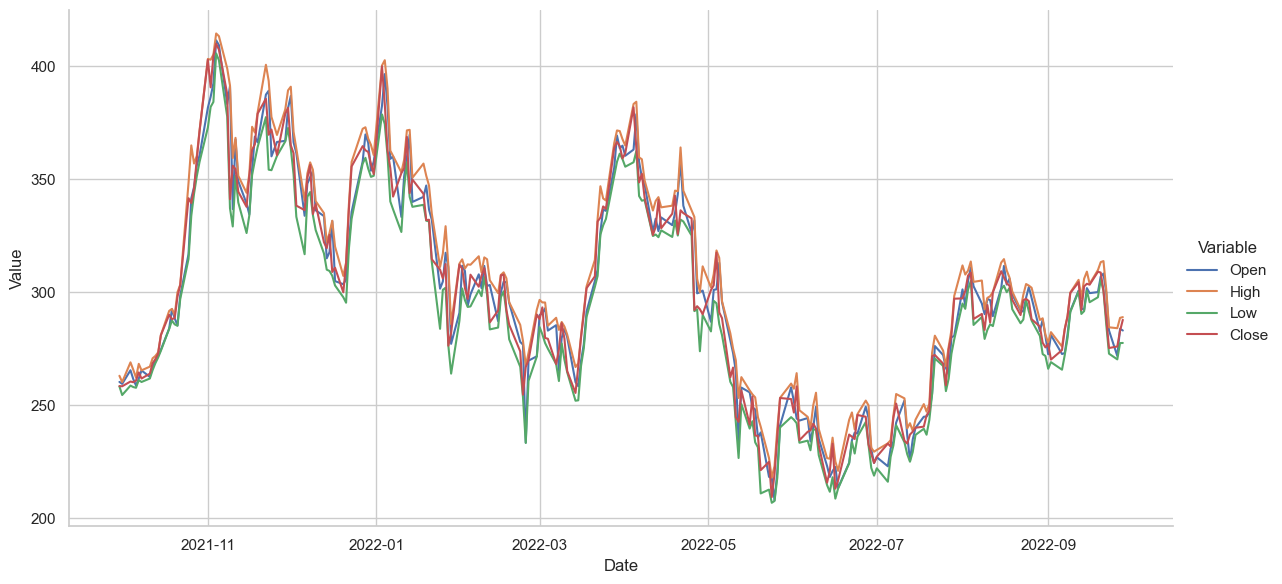

In [43]:
#dfx.reset_index()
# Create a new dataframe with just the relevant columns for plotting
plot_data = dfx[['Date', 'Open', 'High', 'Low', 'Close']]

# Melt the dataframe to "long" format for plotting
plot_data = plot_data.melt(id_vars='Date', var_name='Variable', value_name='Value')

# Use Seaborn to create the time series plot
sns.set_style("whitegrid")
sns.relplot(x='Date', y='Value', hue='Variable', kind='line', data=plot_data, ax=ax, height=6, aspect=2)

plt.show()


In [44]:
dfx

,Date,Tweet,Open,High,Low,Close,Adj Close,Volume,sentiment
0,2021-09-30,"In other words, AMD has been giving Tesla pref...",260.333344,263.043335,258.333344,258.493347,258.493347,53868000,0.9998
1,2021-10-01,Pelosi still scrambling to find enough votes t...,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,0.9998
2,2021-10-04,STOCKS I AM WATCHING THIS WEEK \n\n$CEI \n$AMC...,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,0.9993
3,2021-10-05,Most Mentioned Tickers on WSB (via Swaggy Stoc...,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,0.9992
4,2021-10-06,If you invested $1K into these #assets at the ...,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,0.9998
...,...,...,...,...,...,...,...,...,...
246,2022-09-22,@Teslaconomics Hold tight $TSLA investors. Our...,299.859985,301.290009,285.820007,288.589996,288.589996,70545400,0.9972
247,2022-09-23,3. Scanning for Option Trades\n\nPICK 3-5 Stoc...,283.089996,284.500000,272.820007,275.329987,275.329987,63748400,0.9994
248,2022-09-26,$TSLA - Above 273 - Trade Idea 💡 - Sept 30 280...,271.829987,284.089996,270.309998,276.010010,276.010010,58076900,0.9991
249,2022-09-27,4 years ago today I picked up my dream car. I ...,283.839996,288.670013,277.510010,282.940002,282.940002,61925200,0.9994


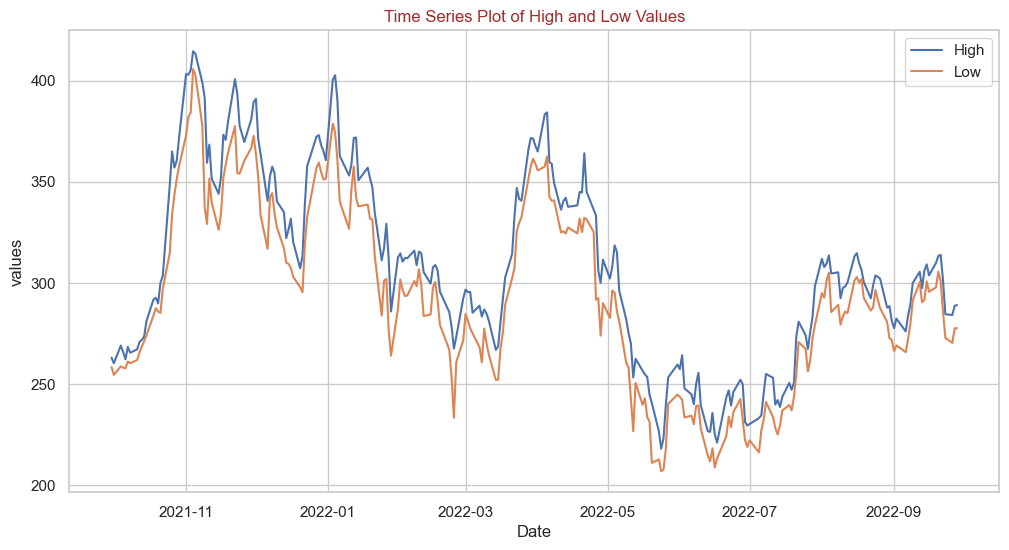

In [45]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12,6)) 
sns.lineplot(x="Date", y ="High", data=dfx, label="High")
sns.lineplot(x="Date", y ="Low", data=dfx, label="Low")
plt.ylabel("values")
plt.title("Time Series Plot of High and Low Values", color="brown")
ax.legend()
plt.show()

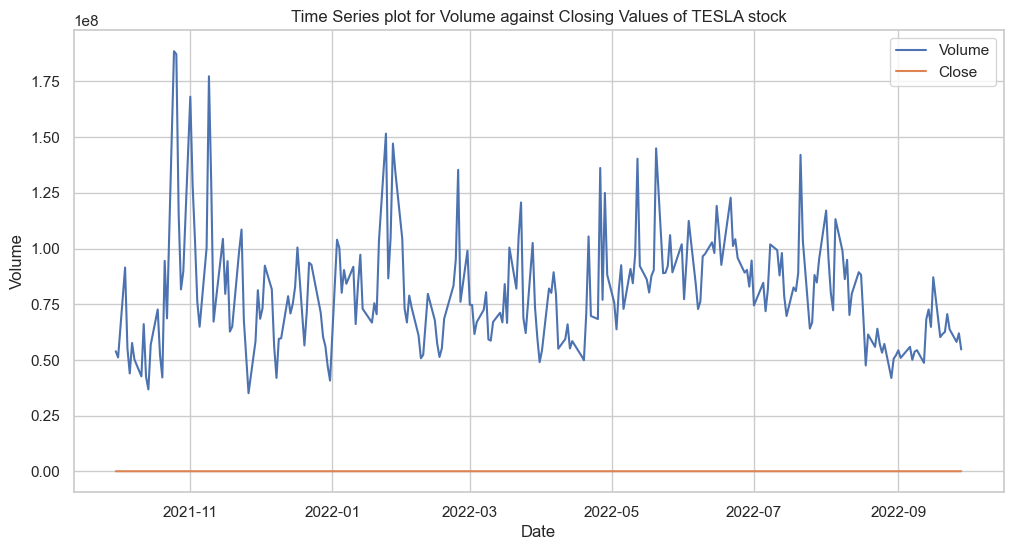

In [46]:
fig, ax = plt.subplots(figsize=(12,6)) 
sns.lineplot(x="Date", y ="Volume", data=dfx, label="Volume")
sns.lineplot(x="Date", y ="Close", data=dfx, label="Close")
plt.title("Time Series plot for Volume against Closing Values of TESLA stock")
plt.show()

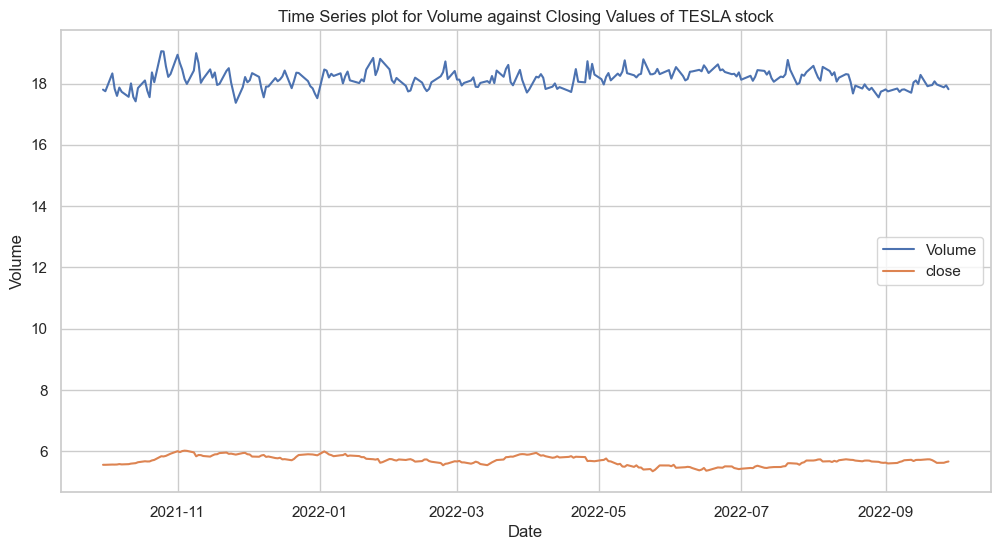

In [47]:
fig, ax = plt.subplots(figsize=(12,6)) 
sns.lineplot(x="Date", y = np.log(dfx["Volume"]),data = dfx, label="Volume")
sns.lineplot(x="Date", y = np.log(dfx["Close"]),data=dfx, label="close")
plt.title("Time Series plot for Volume against Closing Values of TESLA stock")
plt.show()

In [65]:
dfx["mean"] = (dfx["Open"] + dfx["High"] + dfx["Low"] + dfx["Close"] + dfx["Adj Close"])/5
model, rmse, intercept, coef = build_model2(dfx, "rg")

In [66]:
print(f"The equation can be expressed as: Price = {intercept} * sentiment + {coef}")
print(f"The root mean square error is {rmse}")

The equation can be expressed as: Price = 289.4461750534144 * sentiment + [10.68013342]
The root mean square error is 40.39006354436192


In [67]:
#making prediction on a sample string
make_prediction2(". A Status Quo Secretary General. Best Buy and Circuit City Report Brisk Sales for December. \
China Currency Near Parity With Hong Kong’s Dollar. Ex-Merrill Lynch Analyst Sentenced for Insider Trading. \
Companies Pay Dearly for Tech Trade Show. France: Inmate Suspected of Cannibalism. Mr. Ford Gets the Last Laugh. \
San Franciscans Hurl Their Rage at Parking Patrol. Abroad at Home. Monkey on a Tiger. Who Is Best at R&D?.\
Tanzanian Woman Is Chosen for U.N.’s 2nd Highest Post. Leaked Notes on &#8217;08 Show Giuliani Without the Spin.\
Images of Hanging Make Hussein a Martyr to Many. Just Days Into the Year, Killings Toll Hits 8 in New Orleans. \
Regulators Issue Rules on High-Risk Dealings. Iraqi Premier Announces Militia Crackdown.\
Chirac Says Time Proves France Was Right to Resist War. Verizon to Announce Plan for TV Shows on Cellphones. \
Goal Is to Look Good, Writer of Democratic Memoir Admits. Schwarzenegger Opens in a Sequel. San Francisco to Go Wireless.\
Tijuana Police Suspend Patrols After Soldiers Seize Their Guns. Safe as Milk?.\
Editor’s E-Mail May Be Used in Suit Against The Times. A Renegade’s Tale of His Scorn for Japan’s ‘Club of Old Men’. \
China Moves to Tighten the Money Supply. Google Makes Another Investment in the Internet in China.\
Colorado, Still Recovering From 2 Storms, Is Hit With a 3rd. How I Spent My Summer Vacation: Now a Major Motionless Book. \
Surge in Jobs Sends Markets Lower. Katrina Victims Find a Solution: Modular House. A Meeting With Gerald Ford. \
Job Growth Is Strong, Surprising Economists. Encouraging More Reality in Economics. U.N. Expels 6 in Sex Case.\
Germany: Sentence Trial for 9/11 Friend. Britain: New Restaurant on Radiation Trail. Iran Should Give Sanctions &#8216;Serious Response,&#8217; China Says.\
The Senate’s Task on Warming. Ryan Clark Crocker, a Diplomat Used to Danger. Search Continues for Survivors of Indonesian Ferry Accident. The Vanishing Man of the Forest. \
At Armenian Churches, a Distinct Observance Today. Making No Small Plans.\
American Diplomat to Visit Strife-Torn Somali Capital. Zalmay Khalilzad, on to a New Trouble Spot. Ties to Communist Secret Police Snare Polish Bishop.\
Copyrights and Congress. Monument to the Planet Suffers a Hard Fall to Earth. Health Guidelines Suggested for Models. \
France: Paris Driver Opens Fire; No Injuries. Colombia: 6-Year Hostage Flees Rebels. Sri Lanka: Bomb Attack on Bus Kills 5.\
China Media Battle Hints at Shift on Intellectual Property. Highly Paid Chief Is Paid $210 Million to Go Away.\
The Land of Rising Conservation. Viacom Selects President for MTV International Unit.\
Bush Facing Deep Divide Over More Troops for Iraq. At Home Depot, the New Chief Needs to Sell an Old Story to Wall Street. \
Germany: What’s in It for Gelnhausen?. A Future With the Wind. A New Commander, in Step With the White House on Iraq. \
Tipping Over a Defense of Enron. Appeals Court Reverses Convictions of 2 Westar Energy Executives.\
Day After Killings, a Hamas Leader Calls for a Truce. Dow&#8217;s Dogs Still Having Their Day. U.S. and Japan Issue Warnings to North Korea on Nuclear Test.\
Britain: Cartoons Protester Convicted. Chile: California Sailor Rescued. Canada: Liberal Lawmaker Defects. Battlegrounds: An Op-Ed Series. Sunday's Breakfast Menu: Jan. 7.\
Who Will Bring the Internet to Your TV?. Fun Facts. Tesla Chargers. The Macworld-C.E.S. Conflict. In da Car at Dakar", model)

'Predicted Stock price: $279.14'

****
# Saving the model
The developed model is saved using the joblib library

In [68]:
import joblib
joblib.dump(model, "Stock_price_model.joblib")

['Stock_price_model.joblib']